## Global SP mode run

In [1]:
from scipy.stats import qmc
import numpy as np

import csv
import xarray as xr
import pandas as pd
import os
import netCDF4 as nc4
import sys
import shutil
from tempfile import TemporaryFile                                                                                                                                 
import argparse                                                                                                                                                                                                                                                                                                       
import tempfile 
import random
import re

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import cm
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize
from matplotlib.colors import BoundaryNorm
import cartopy.crs as ccrs

import functions_py.fates_xarray_functions as fa


### Load FATES

In [2]:
fates_atkin = '/pscratch/sd/j/jneedham/elm_runs/sp_cal/sp_f45.Eb8be65d66e-Ffc130cb8.2023-10-15/run/sp_f45.Eb8be65d66e-Ffc130cb8.2023-10-15.elm.h0.1910s.nc'
fates_atkin = xr.open_dataset(fates_atkin,  decode_times=False)

time = fates_atkin.variables['time'] / 365.
cohort_size_bins = fates_atkin.variables['fates_levscls'][:]
nsizebins = len(cohort_size_bins)

tave_start =  10
tave_stop = 15

pftnames = ['broadleaf_evergreen_tropical_tree','needleleaf_evergreen_extratrop_tree',
         'needleleaf_colddecid_extratrop_tree','broadleaf_evergreen_extratrop_tree',
        'broadleaf_hydrodecid_tropical_tree','broadleaf_colddecid_extratrop_tree',
        'broadleaf_evergreen_extratrop_shrub','broadleaf_hydrodecid_extratrop_shrub',
        'broadleaf_colddecid_extratrop_shrub', 'arctic_c3_grass',
        'cool_c3_grasss','c4_grass']

In [3]:
def decay_coeff_kn(vcmax25top):
    ans = np.exp(0.00963 * vcmax25top - 2.43)
    return ans


def clllpf_to_cn_lf_by_pft(clllpf_var, dataset, dataset2):
    """function to reshape a fates multiplexed canopy layer, leaf layer and pft-indexed variable to one indexed by canopy layer leaf layer and pft
    first argument should be an xarray DataArray that has the FATES CLLLPF dimension
    second argument should be an xarray Dataset that has the FATES CLLL dimensions
    (possibly the dataset encompassing the dataarray being transformed)
    returns an Xarray DataArray with the cnlf  (CLLL) and pft dimensions disentangled"""
    n_cnlf = len(dataset.fates_levcnlf)
    ds_out = (clllpf_var.rolling(fates_levcnlfpf=n_cnlf, center=False)
            .construct("fates_levcnlf")
            .isel(fates_levcnlfpf=slice(n_cnlf-1, None, n_cnlf))
            .rename({'fates_levcnlfpf':'fates_levpft'})
            .assign_coords({'fates_levcnlf':dataset.fates_levcnlf})
            .assign_coords({'fates_levpft':dataset.fates_levpft}))
    ds_out.attrs['long_name'] = clllpf_var.attrs['long_name']
    ds_out.attrs['units'] = clllpf_var.attrs['units']
    
    # now create a new dimension - leaf layers - and disentangle canopy layers and leaf layers
    n_levleaf = len(dataset2.fates_levleaf)
    ds_out2 = (ds_out.rolling(fates_levcnlf=n_levleaf, center=False)
               .construct("fates_levleaf")
               .isel(fates_levcnlf=slice(n_levleaf-1, None, n_levleaf))
               .rename({'fates_levcnlf':'fates_levcan'})
               .assign_coords({'fates_levleaf':dataset2.fates_levleaf})
               .assign_coords({'fates_levcan':dataset.fates_levcan}))
    ds_out2.attrs['long_name'] = ds_out.attrs['long_name']
    ds_out2.attrs['units'] = ds_out.attrs['units']
    
    return(ds_out2)

### Calculate leaf construction cost per pft

In [4]:
# Leaf construction cost depends on cumulative LAI which corresponds to the leaf layer 
# dimension in CLLLPF. Therefore calculate leaf construction cost for each leaf layer and
# subtract from NET_C_UPTAKE_CLLLPF to get the full net C uptake. 

# PFT level parameters 
vcmax25top = [57.5, 34.1, 33.15, 33.55, 28.7, 31.9, 71.3, 62.1, 37.8, 42.9, 31.2, 78]
slatop = [0.0144, 0.006, 0.0288, 0.0108, 0.036, 0.036, 0.0144, 0.036, 0.036, 0.036, 0.036, 0.03]
slamax = [0.0954, 0.0954, 0.0954, 0.0954, 0.0954, 0.0954, 0.012, 0.03, 0.03, 0.03, 0.03, 0.03]
root_long = [1, 2, 1, 1.5, 1, 1, 1.5, 1, 1, 1, 1, 1]
leaf_long = [1.5, 4, 1, 1.5, 1, 1, 1.5, 1, 1, 1, 1, 1]
season_decid = [0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0]
stress_decid = [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1]
grperc = [ 0.22, 0.22, 0.22, 0.22, 0.22, 0.22, 0.22, 0.22, 0.22, 0.22, 0.22, 0.22]
l2fr = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

vai_top_bin_width = 0.1
vai_width_increase_factor = 1.1
nlevleaf = 37 # it is actually 36 but do 37 here to get midpoints
z = np.linspace(1,nlevleaf,nlevleaf)
dinc_vai = vai_top_bin_width * vai_width_increase_factor ** z
cumulative_lais = np.cumsum(dinc_vai)

lower = cumulative_lais[0:-1]
upper = cumulative_lais[1:]
leaf_layer_mids = (lower + upper)*0.5

# make a dataset that has a fates_levleaf dimension
data = np.arange(36)
locs = leaf_layer_mids
dataset2 = xr.DataArray(data, coords={'fates_levleaf':locs}, dims = 'fates_levleaf')


### Leaf costs

In [5]:
leaf_costs = []

# This is kg C m-2 yr-1 (per unit ground area?)
for pf in range(len(pftnames)):
    
    pft_kn = decay_coeff_kn(vcmax25top[pf])
    nscaler_levleaf = np.exp(-pft_kn * leaf_layer_mids)  
    sla_levleaf = slatop[pf] / nscaler_levleaf
    m = [idx for idx in range(len(sla_levleaf)) if sla_levleaf[idx] > slamax[pf]]
    sla_levleaf[m] = slamax[pf]
    
    # if deciduous
    if(season_decid[pf] == 1) or (stress_decid[pf] == 1):
        # account for sla profile 
        leaf_cost = 1 / (sla_levleaf * 1000) 
        # growth respiration tax
        leaf_cost = (leaf_cost * (grperc[pf] + 1))
    
    # if evergreen    
    else : 
        leaf_cost = (1 / (sla_levleaf * 1000 * leaf_long[pf])) 
        leaf_cost = (leaf_cost * (grperc[pf] + 1)) 
    
    bfr_per_bleaf = l2fr[pf]
    leaf_cost = leaf_cost + ( 1 / (sla_levleaf * 1000) * bfr_per_bleaf / root_long[pf] )
    
    leaf_costs.append(leaf_cost)
    
    
leaf_costs = xr.DataArray(leaf_costs, dims = ['fates_levpft', 'fates_levleaf'], coords=[np.arange(len(l2fr))+1, leaf_layer_mids])    


### Atkin

In [6]:
# untangle all the dimensions  - this variable is in kg C m-2 s-1 (per ground area NOT leaf area)
ds5_raw_atkin = clllpf_to_cn_lf_by_pft(fates_atkin['FATES_NET_C_UPTAKE_CLLLPF'], fates_atkin, dataset2) 

# max area of each pft in no comp
pft_frac_atkin = fates_atkin.FATES_NOCOMP_PATCHAREA_PF  # in m2 m-2

# Subtract leaf costs from net C uptake ( make net C uptake annual)
ds5_atkin = ds5_raw_atkin/pft_frac_atkin * (pft_frac_atkin/pft_frac_atkin) * 86400 * 365
ds6_atkin = ds5_atkin - leaf_costs

# Now in kg C m-2 yr-1

# average over time and remove empty canopy layers
# remove empty canopy layer
ds7_atkin = ds6_atkin.isel(fates_levcan=0)

# mean over time
ds8_atkin = ds7_atkin.mean(dim='time')

# sum over pfts
ds9_atkin = (ds5_raw_atkin * 86400 * 365 - leaf_costs*pft_frac_atkin).isel(fates_levcan=0).mean(dim='time').sum(dim='fates_levpft')


## equilibrium LAI for each PFT 

### Atkin

In [7]:
lastpositivelevel = (ds8_atkin > 0.).sum(dim='fates_levleaf')
equilibrium_lai_atkin = lastpositivelevel.copy()
for ipft in range(len(lastpositivelevel.fates_levpft)):
    for ilat in range(len(lastpositivelevel.lat)):
        for ilon in range(len(lastpositivelevel.lon)):
            if lastpositivelevel[ipft,ilat,ilon] > 0:
                equilibrium_lai_atkin[ipft,ilat,ilon] = leaf_layer_mids[lastpositivelevel[ipft,ilat,ilon]]
            else:
                equilibrium_lai_atkin[ipft,ilat,ilon] = np.nan
                
equilibrium_lai_atkin = equilibrium_lai_atkin * (ds8_atkin.sum(dim='fates_levleaf')/ds8_atkin.sum(dim='fates_levleaf'))


/global/homes/j/jneedham/.conda/envs/myenv/lib/python3.9/site-packages/xarray/plot/facetgrid.py:392: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self.fig.tight_layout()


''

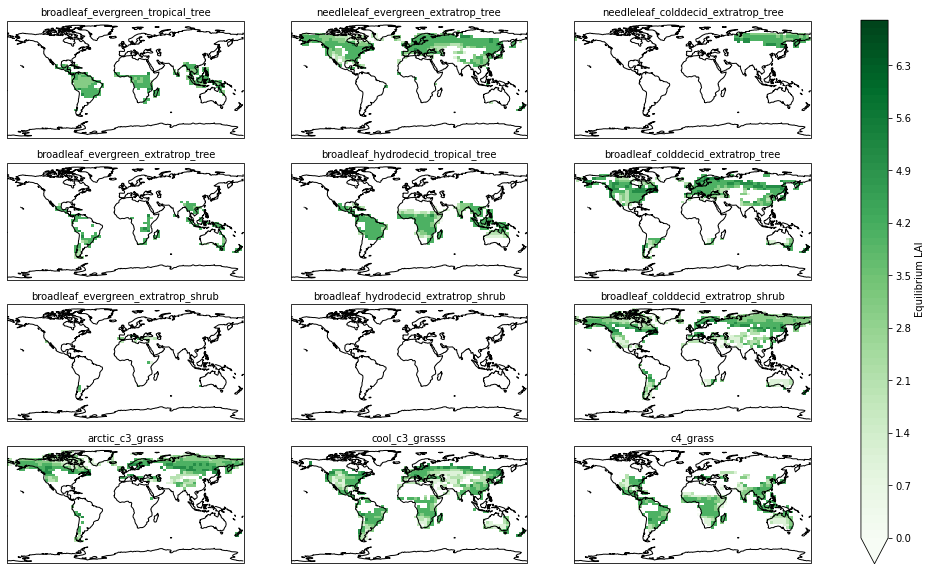

In [8]:
g = equilibrium_lai_atkin.plot(x="lon",y="lat",col="fates_levpft", col_wrap=3, 
           figsize=(18, 10),
      cbar_kwargs={"label": "Equilibrium LAI"},
      subplot_kws={"projection":ccrs.PlateCarree(),"facecolor":"white"},
          levels = np.arange(0,7,0.1), cmap='Greens',
            facecolor="white")

for i, ax in enumerate(g.axes.flat):
    ax.set_title(pftnames[i], fontsize=10)

[ax.coastlines() for ax in g.axes.flatten()]

;

### Plot just tropical v modis LAI

In [9]:
lai_canopy = fa.scpf_to_scls_by_pft(fates_atkin.FATES_LAI_CANOPY_SZPF, fates_atkin)
lai_canopy = lai_canopy.sum(dim='fates_levscls').max(dim='time')
lai_ustory = fa.scpf_to_scls_by_pft(fates_atkin.FATES_LAI_USTORY_SZPF, fates_atkin)
lai_ustory = lai_ustory.sum(dim='fates_levscls').max(dim='time')
lai = lai_canopy+lai_ustory

In [10]:
print(lai.shape)
print(equilibrium_lai_atkin.shape)

(12, 46, 72)
(12, 46, 72)


In [11]:
lai_trop = lai.isel(fates_levpft = 0)
lai_eq_trop = equilibrium_lai_atkin.isel(fates_levpft = 0)

print(lai_trop.shape)

(46, 72)


Text(0.5, 1.0, 'LAI - MODIS')

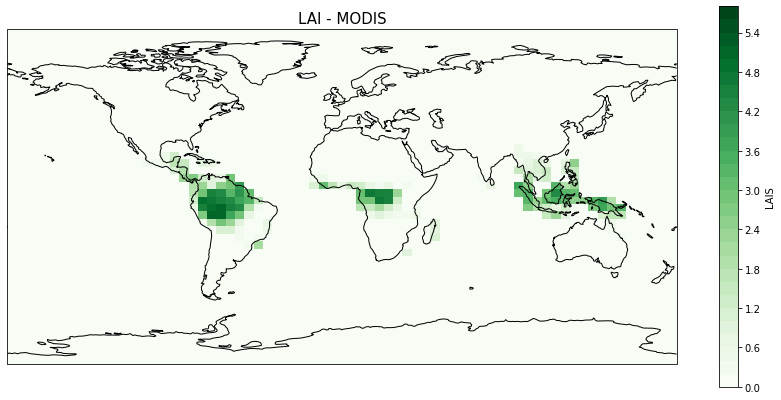

In [16]:
fig2, ((f2ax0)) = plt.subplots(nrows=1,ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(15,7))

clevs = np.arange(0,6,0.2)

lai_trop.plot(levels=clevs,transform=ccrs.PlateCarree(),cmap='Greens',
         cbar_kwargs={"label": "LAIS"}, ax=f2ax0)
f2ax0.coastlines()
f2ax0.set_title('LAI - MODIS', fontsize=15)


Text(0.5, 1.0, 'Maximum equilibrium LAI')

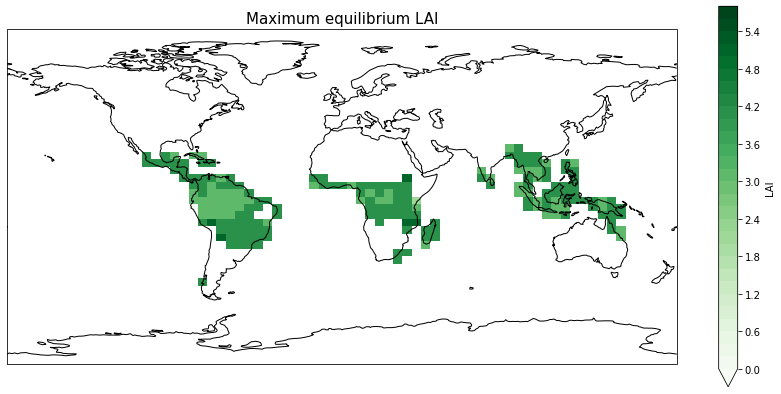

In [17]:
fig2, ((f2ax0)) = plt.subplots(nrows=1,ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(15,7))

clevs = np.arange(0,6,0.2)

lai_eq_trop.plot(levels=clevs,transform=ccrs.PlateCarree(),cmap='Greens',
         cbar_kwargs={"label": "LAI"}, ax=f2ax0)
f2ax0.coastlines()
f2ax0.set_title('Maximum equilibrium LAI', fontsize=15)


In [18]:
diff = lai_eq_trop - lai_trop 

Text(0.5, 1.0, 'Max equilibrium LAI - MODIS')

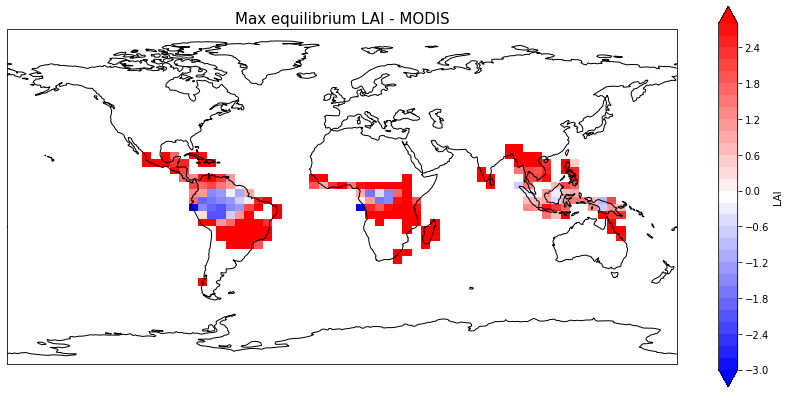

In [20]:
fig2, ((f2ax0)) = plt.subplots(nrows=1,ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(15,7))

clevs = np.arange(-3,3,0.2)

diff.plot(levels=clevs,transform=ccrs.PlateCarree(),cmap='bwr',
         cbar_kwargs={"label": "LAI"}, ax=f2ax0)
f2ax0.coastlines()
f2ax0.set_title('Max equilibrium LAI - MODIS', fontsize=15)
